<img src="logo_skmob.png" align="left" width="350">

# Privacy

- Repo: [http://bit.ly/skmob_repo](http://bit.ly/skmob_repo)
- Docs: [http://bit.ly/skmob_doc](http://bit.ly/skmob_doc)
- Paper: [http://bit.ly/skmob_paper](http://bit.ly/skmob_paper)

# **Privacy Risk Assessment**

Simulate privacy attacks and assess risk with a worst-case scenario framework

First, we import the necessary modules

In [1]:
from skmob.core.trajectorydataframe import TrajDataFrame
from skmob.privacy import attacks
import pandas as pd

We will use a subset of the **Geolife** dataset for demonstration. The whole dataset is [here](https://www.microsoft.com/en-us/download/details.aspx?id=52367)

In [2]:
trjs = TrajDataFrame.from_file(
    './data/geolife.csv', sep=',')

FileNotFoundError: File b'./data/geolife.csv' does not exist

We need to preprocess the data to clean it out, as shown before

## Preprocessing: generalazing trajectories. Why so?

- Generalization and deletion are one of the most common ways in which a data holder can prepare the data for sharing/release. 
- Unprocessed data has usually a very fine grain that can lead to really high levels of privacy risk in the assessment phase

In [ ]:
from skmob.preprocessing import filtering
ftrjs = filtering.filter(trjs, max_speed_kmh=500.)

In [ ]:
from skmob.preprocessing import compression
ctrjs = compression.compress(ftrjs, spatial_radius_km=0.2)

In [ ]:
from skmob.preprocessing import detection
strjs= detection.stops(ctrjs, stop_radius_factor=0.8, \
            minutes_for_a_stop=30.0, spatial_radius_km=0.5, 
                       leaving_time=True)

## Clustering Trajectories
Clustering helps with generalization, thus reducing privacy risk
It is important to group points into "cells"

In [ ]:
from skmob.preprocessing import clustering
clust_trjs = clustering.cluster(strjs, cluster_radius_km=0.5, min_samples=1)

We can see how many distinct cluster we obtain. We will use the centroids of the clusters for privacy risk assessment instead of the single points

In [ ]:
len(pd.unique(clust_trjs["cluster"]))

We compute the centroid and then we merge them with the original data

In [ ]:
centroids = clust_trjs.groupby("cluster").mean().reset_index()
centroids = centroids.rename(columns={"uid":"wrong_uid"})
centroids_traj = clust_trjs.rename(columns={"lat":"latitude","lng":"longitude"})
centroids_traj = pd.merge(centroids_traj,centroids,left_on="cluster",right_on="cluster")
privacy_trjs = centroids_traj[["datetime","lat","lng","uid"]]

We save the processed data to save time

In [ ]:
privacy_trjs.to_csv("data/geolife_privacy.csv",index=False)

In [2]:
privacy_trjs = TrajDataFrame.from_file("data/geolife_privacy.csv")

## Setting up attacks
Each type of attack is a separate class inheriting from a generic `Attack` class. 
We can instatiante an attack model by specifying the length `knowledge_length` of the background knowledge that we want to simulate.

In [22]:
at = attacks.LocationFrequencyAttack(knowledge_length=2,tolerance=0.5)

To compute privacy risk for all users, simply call the `assess_risk` function on the trajectory dataframe. We will use just a portion of the data for demonstration.

In [ ]:
privacy_trjs_tr = privacy_trjs[privacy_trjs["uid"].isin(pd.unique(privacy_trjs["uid"])[:20])]

In [6]:
r2 = at2.assess_risk(privacy_trjs_tr, show_progress=True)

computing risk: 100%|██████████| 20/20 [18:06<00:00, 45.04s/it]


In [21]:
r2

,uid,risk
0,0,1.000000
1,1,0.250000
2,2,0.500000
3,3,1.000000
4,4,1.000000
5,7,1.000000
6,10,1.000000
7,11,0.333333
8,12,0.500000
9,13,1.000000


In [7]:
r2[r2["risk"] < 1]

,uid,risk
1,1,0.250000
2,2,0.500000
7,11,0.333333
8,12,0.500000
11,16,0.500000


## Assessment options
To change the size of the background knowledge, we can either change the `knowledge_length` parameter or instantiate a new attack model.

In [25]:
at.knowledge_length = 3
r3 = at.assess_risk(privacy_trjs_tr,show_progress=True)

computing risk: 100%|██████████| 20/20 [54:55<00:00, 55.54s/it]  


In [29]:
r3[r3["risk"] < 1]

,uid,risk
1,1,0.333333
2,2,0.500000
7,11,0.333333
11,16,0.500000


Not all background knowledge instances may be evaluated during the assessment: if an instance has risk equal to 1.0, the following combinations are discarded.

If you want to show all possible instances, use the `force_instances` parameter.
As all instances are computed, this may require long times and high memory usage.

Combinations are identified by the attribute `instance` while the elements in the instance are indicated with the attribute `instance_elem`. 

We can also use the option `targets` to specify the subset of the individuals on which to perform privacy risk assessment. Risk is still computed against the whole dataset.

To check on the progress, we can use the `show_progress` attribute

In [27]:
at.assess_risk(privacy_trjs_tr, force_instances=True, targets=[1,11], show_progress=True)

computing risk: 100%|██████████| 2/2 [02:46<00:00, 83.19s/it]


,lat,lng,datetime,uid,instance,instance_elem,prob
0,1.0,37.677510,113.264952,1.0,1,1,0.100000
1,1.0,37.934231,113.377891,1.0,1,2,0.100000
2,1.0,37.995852,90.888742,1.0,1,3,0.100000
3,1.0,37.677510,113.264952,1.0,2,1,0.100000
4,1.0,37.934231,113.377891,1.0,2,2,0.100000
5,1.0,38.324604,115.732652,1.0,2,3,0.100000
6,1.0,37.677510,113.264952,1.0,3,1,0.100000
7,1.0,37.934231,113.377891,1.0,3,2,0.100000
8,1.0,38.333659,111.374805,1.0,3,3,0.100000
9,1.0,37.677510,113.264952,1.0,4,1,0.100000


We recall that complexity is dominated by the number of combinations
The number of combinations generated depends on:
- length of the background knowledge
- the average length of each user's trajectory. 

\begin{equation*}
\mathcal{O} \Bigl(  \binom{l}{k} |T|  matching \Bigr)
\end{equation*}

- $l$ is the length of the current trajectory considered
- $k$ is the background knowledge length
- $T$ is the set of all target trajectories
- $matching$ stands for the cost of the matching operation between each combination and the data.

## Attack Models
The library provides eight attack models, each with a different background knowledge:
 - `LocationAttack`: uses the locations visited.
 - `LocationSequenceAttack`: uses the locations visited with information about the order of visit
 - `LocationTimeAttack`: uses the locations visited and the time of visit. A precision for the time can be specified

- `UniqueLocationAttack`: uses the unique locations visited, i.e., disregarding repeated visits to a same location. It operates on frequency vectors
- `LocationFrequencyAttack`: uses the unique locations visited and the frequency with which they were visited. It operates on frequency vectors
- `LocationProbabilityAttack`: uses the unique locations visited and the probability with which they were visited. It operates on probability vectors

 - `LocationProportionAttack`: uses the unique locations visited and the relative proportion of the frequencies of visit. It operates on frequency vectors
 - `HomeWorkAttack`: uses the two most visited locations

## Understaing the matching mechanic
In the data folder of the scikit-mobility github, you can find a simple toy dataset that can be used to better understand the mechanics of every attack

In [31]:
toy = TrajDataFrame.from_file(filename="./data/privacy_toy.csv")

In [32]:
toy

,lat,lng,datetime,uid
0,43.843014,10.507994,2011-02-03 08:34:04,1
1,43.544270,10.326150,2011-02-03 09:34:04,1
2,43.708530,10.403600,2011-02-03 10:34:04,1
3,43.779250,11.246260,2011-02-04 10:34:04,1
4,43.843014,10.507994,2011-02-03 08:34:04,2
5,43.708530,10.403600,2011-02-03 09:34:04,2
6,43.843014,10.507994,2011-02-04 10:34:04,2
7,43.544270,10.326150,2011-02-04 11:34:04,2
8,43.544270,10.326150,2011-02-03 08:34:04,3
9,43.708530,10.403600,2011-02-03 09:34:04,3


In [34]:
at = attacks.LocationAttack(knowledge_length=2)
r_toy = at.assess_risk(toy, targets=[1], force_instances=True)
r_toy

,lat,lng,datetime,uid,instance,instance_elem,prob
0,43.843014,10.507994,2011-02-03 08:34:04,1,1,1,0.250000
1,43.544270,10.326150,2011-02-03 09:34:04,1,1,2,0.250000
2,43.843014,10.507994,2011-02-03 08:34:04,1,2,1,0.250000
3,43.708530,10.403600,2011-02-03 10:34:04,1,2,2,0.250000
4,43.843014,10.507994,2011-02-03 08:34:04,1,3,1,0.250000
5,43.779250,11.246260,2011-02-04 10:34:04,1,3,2,0.250000
6,43.544270,10.326150,2011-02-03 09:34:04,1,4,1,0.250000
7,43.708530,10.403600,2011-02-03 10:34:04,1,4,2,0.250000
8,43.544270,10.326150,2011-02-03 09:34:04,1,5,1,0.333333
9,43.779250,11.246260,2011-02-04 10:34:04,1,5,2,0.333333


The background knowledge for a Location Attack consists of locations, with no information about the order of visits to it.
If we look at the first background knowledge instance, the information used is then:

In [39]:
from skmob.utils import constants
toy[toy[constants.UID] == 1][[constants.LATITUDE, 
                                    constants.LONGITUDE]].iloc[0:2]

,lat,lng
0,43.843014,10.507994
1,43.544270,10.326150


We can clearly see that the matches for this instance are individuals 1, 2, 3 and 6

In [40]:
toy[toy[constants.UID].isin([1,2,3,6])]

,lat,lng,datetime,uid
0,43.843014,10.507994,2011-02-03 08:34:04,1
1,43.544270,10.326150,2011-02-03 09:34:04,1
2,43.708530,10.403600,2011-02-03 10:34:04,1
3,43.779250,11.246260,2011-02-04 10:34:04,1
4,43.843014,10.507994,2011-02-03 08:34:04,2
5,43.708530,10.403600,2011-02-03 09:34:04,2
6,43.843014,10.507994,2011-02-04 10:34:04,2
7,43.544270,10.326150,2011-02-04 11:34:04,2
8,43.544270,10.326150,2011-02-03 08:34:04,3
9,43.708530,10.403600,2011-02-03 09:34:04,3


## Additional parameters for attacks

Some attacks, such as `LocationTimeAttack` for example, need some additional parameters for initialization. The detail of each attack can be found in the documentation. Let's see an example of a powerful attack.

`LocationTimeAttack` uses the informaton about the location visited and the time of visit 

In [41]:
at = attacks.LocationTimeAttack(knowledge_length=2, time_precision="Day")

We specify the precision with witch to consider the temporal information of the trajectories

In [45]:
r_time = at.assess_risk(privacy_trjs_tr)

In [46]:
r_time

,uid,risk
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0
5,7,1.0
6,10,1.0
7,11,1.0
8,12,1.0
9,13,1.0


In [47]:
r[r["risk"] < 1]

,uid,risk


We can see that, for powerful attacks, risk can be really high, despite our efforts to generalize trajectories

## Visualizing and understanding risk
Risk may be visualized in many different ways. A very simple and intuitive way is a cumulative distribution function.

In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [104]:
results = [r2,r3,r_time]
colors = ["red","blue","green"]
styles = ["-","--",":"]
labels = ["Frequency k2", "Frequency k3", "Location Time k2 Hour"]
fontsize = 20

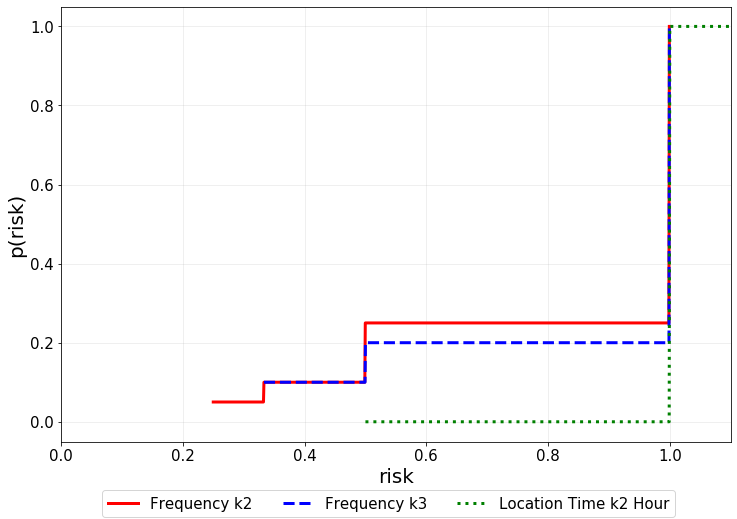

In [108]:
plt.figure(figsize=(12,8))
for i in range(0,len(results)):
    data = results[i]["risk"].tolist()
    values, base = np.histogram(data, bins=1000)
    cumulative = np.cumsum(values)
    plt.plot(base[:-1],cumulative/len(data), c=colors[i], label=labels[i], linestyle=styles[i],linewidth=3)
plt.xlim(0,1.1)
plt.xlabel("risk",size=fontsize)
plt.ylabel("p(risk)", size=fontsize)
plt.xticks(size=fontsize-5)
plt.yticks(size=fontsize-5)
plt.grid(alpha=0.25)
plt.figlegend(labels, loc = 'lower center',bbox_to_anchor=(0.45, -0.01), ncol=3,  fontsize = fontsize-5, labelspacing=0. )
plt.show()

# Conclusions
- Evaluating risk is not an immediate task. It depends on the kind of data you are using, on the purpose of your analysis, on the properties you want to maintain.
- Privacy risk has to be explored thoroughly with different attack models and different configurations
- For mobility data preprocessing data is paramount. Risk assessment can be performed with diversely processed data in order to understand the "best" format for release